In [1]:
#导入MindSpore模块和辅助模块：

import os
# os.environ['DEVICE_ID'] = '7'
import csv
import numpy as np

import mindspore as ms
from mindspore import nn
from mindspore import context
from mindspore import dataset
from mindspore.train.callback import LossMonitor

# context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

In [2]:
#读取Iris数据集`iris.data`，并作检查
with open('iris.data') as csv_file:
    data = list(csv.reader(csv_file, delimiter=','))
print(data[0:5]); print(data[50:55]); print(data[100:105]) # 打印部分数据

[['5.1', '3.5', '1.4', '0.2', 'Iris-setosa'], ['4.9', '3.0', '1.4', '0.2', 'Iris-setosa'], ['4.7', '3.2', '1.3', '0.2', 'Iris-setosa'], ['4.6', '3.1', '1.5', '0.2', 'Iris-setosa'], ['5.0', '3.6', '1.4', '0.2', 'Iris-setosa']]
[['7.0', '3.2', '4.7', '1.4', 'Iris-versicolor'], ['6.4', '3.2', '4.5', '1.5', 'Iris-versicolor'], ['6.9', '3.1', '4.9', '1.5', 'Iris-versicolor'], ['5.5', '2.3', '4.0', '1.3', 'Iris-versicolor'], ['6.5', '2.8', '4.6', '1.5', 'Iris-versicolor']]
[['6.3', '3.3', '6.0', '2.5', 'Iris-virginica'], ['5.8', '2.7', '5.1', '1.9', 'Iris-virginica'], ['7.1', '3.0', '5.9', '2.1', 'Iris-virginica'], ['6.3', '2.9', '5.6', '1.8', 'Iris-virginica'], ['6.5', '3.0', '5.8', '2.2', 'Iris-virginica']]


In [3]:
#数据集的3类样本共150条，将样本的4个属性作为自变量$X$，将样本的3个类别映射为{0, 1, 2}，作为因变量$Y$。
label_map = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
}
X = np.array([[float(x) for x in s[:-1]] for s in data[:150]], np.float32)
Y = np.array([label_map[s[-1]] for s in data[:150]], np.int32)

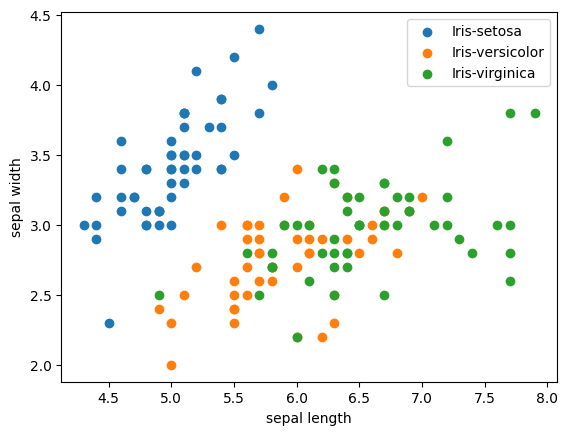

In [4]:
#取样本的前两个属性进行2维可视化，可以看到在前两个属性上其中一类和余下两类是线性可分的，而余下两类之间线性不可分。
from matplotlib import pyplot as plt
plt.scatter(X[:50, 0], X[:50, 1], label='Iris-setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], label='Iris-versicolor')
plt.scatter(X[100:, 0], X[100:, 1], label='Iris-virginica')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [5]:
#将数据集按8:2划分为训练集和验证集
train_idx = np.random.choice(150, 120, replace=False)
test_idx = np.array(list(set(range(150)) - set(train_idx)))
X_train, Y_train = X[train_idx], Y[train_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

In [6]:
#使用MindSpore`GeneratorDataset`接口将numpy.ndarray类型的数据转换为Dataset
XY_train = list(zip(X_train, Y_train))
ds_train = dataset.GeneratorDataset(XY_train, ['x', 'y'])
# ds_train.set_dataset_size(120)
print(ds_train.get_dataset_size())
ds_train = ds_train.shuffle(buffer_size=120).batch(32, drop_remainder=True)

XY_test = list(zip(X_test, Y_test))
ds_test = dataset.GeneratorDataset(XY_test, ['x', 'y'])
# ds_test.set_dataset_size(30)
print(ds_test.get_dataset_size())
ds_test = ds_test.batch(30)

120
30


In [7]:
net = nn.Dense(4, 3)
loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
opt = nn.optim.Momentum(net.trainable_params(), learning_rate=0.05, momentum=0.9)


In [9]:
model = ms.train.Model(net, loss, opt, metrics={'acc', 'loss'})
model.train(25, ds_train, callbacks=[LossMonitor(per_print_times=ds_train.get_dataset_size())], dataset_sink_mode=False)
metrics = model.eval(ds_test)
print(metrics)

epoch: 1 step: 3, loss is 1.2472995519638062
epoch: 2 step: 3, loss is 0.8281484246253967
epoch: 3 step: 3, loss is 0.8408597111701965
epoch: 4 step: 3, loss is 0.5111450552940369
epoch: 5 step: 3, loss is 0.35983097553253174
epoch: 6 step: 3, loss is 0.3670760989189148
epoch: 7 step: 3, loss is 0.5509686470031738
epoch: 8 step: 3, loss is 0.496765673160553
epoch: 9 step: 3, loss is 0.32943302392959595
epoch: 10 step: 3, loss is 0.3332585394382477
epoch: 11 step: 3, loss is 0.37768465280532837
epoch: 12 step: 3, loss is 0.42057421803474426
epoch: 13 step: 3, loss is 0.2944069504737854
epoch: 14 step: 3, loss is 0.20146623253822327
epoch: 15 step: 3, loss is 0.17078766226768494
epoch: 16 step: 3, loss is 0.2070620208978653
epoch: 17 step: 3, loss is 0.2229190319776535
epoch: 18 step: 3, loss is 0.19843335449695587
epoch: 19 step: 3, loss is 0.23351967334747314
epoch: 20 step: 3, loss is 0.19495238363742828
epoch: 21 step: 3, loss is 0.2326209545135498
epoch: 22 step: 3, loss is 0.158275

Test accuracy is 1.0


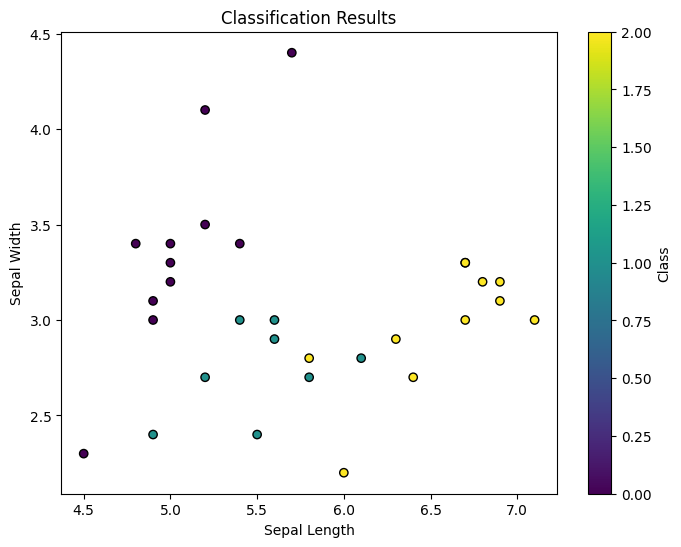

In [10]:
import mindspore as ms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 获取模型在测试集上的预测结果
x = model.predict(ms.Tensor(X_test)).asnumpy()
pred = np.argmax(x, axis=1)  # 对于多分类，选择概率最大的类别

# 计算准确率
correct = np.equal(pred, Y_test)
acc = np.mean(correct)
print('Test accuracy is', acc)

# 可视化输出（基于前两个特征进行可视化）
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=pred, cmap='viridis', marker='o', edgecolor='k', label='Predicted Classes')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('Classification Results')
plt.colorbar(label='Class')
plt.show()
